## Path Finding and Freight Forwarding Recommendations

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [196]:
from graphdatascience import GraphDataScience

# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience('neo4j://localhost', auth=('neo4j', 'neo'))

In [197]:
def clear_all_graphs():
    g_names = gds.graph.list().graphName.tolist()
    for g_name in g_names:
        g = gds.graph.get(g_name)
        gds.graph.drop(g)

## Route Statistics from Historic Shipments

In [198]:
#what are the most common paths in the data set?
routes_df = gds.run_cypher('''
    MATCH(e:EntryPoint)-[r:RECEPTION]->()
    WITH e.airportId AS sourceId, e.name AS sourceName, r.shipmentId AS shipmentId, r.legId AS incomingLegId
    MATCH (d:Destination)<-[r:DELIVERY {shipmentId: shipmentId}]-()
    RETURN sourceId, sourceName, d.airportId AS targetId, d.name AS targetName, collect(shipmentId) AS shipmentIds, count(*) AS shipmentCount,
        (sourceId = d.airportId) AS circular
    ORDER BY circular ASC, shipmentCount DESC
''')
routes_df

,sourceId,sourceName,targetId,targetName,shipmentIds,shipmentCount,circular
0,815,Moodytown,700,Davisfort,"[2834, 2326, 1663, 1861, 1343, 1211, 2558, 775, 2953, 1718, 605, 226, 1035, 1145, 1846, 1224, 1767, 1846, 1588, 3002, 2774, 1553, 160, 1157, 627, 567, 3167, 1343, 1145, 1577, 1471, 128, 2953, 2425, 1260, 2176, 698, 1067, 424, 1035, 833, 1490, 35, 1586, 1145, 2674, 1343, 2485, 1983, 108, 627, 698, 1650, 128, 517, 2921, 307, 2227, 460, 1127, 58, 2633, 1214, 3002, 1035, 1927, 1260, 1375, 246, 149, 1846, 2176, 1283, 2056, 1072, 832, 1484, 464, 2024, 1267, 2774, 1000, 1224, 1323]",84,False
1,815,Moodytown,742,Josephton,"[3749, 1681, 1683, 3146, 3415, 3032, 3721, 891, 3727, 2569, 3674, 3146, 3886, 3727, 2387, 873, 3124, 3911, 2167, 3438, 3597, 2059, 2483, 3431, 3497, 3749, 3897, 3702, 3741, 822, 2119, 3727, 3415, 1683, 3385, 3471, 1856, 3045, 2730, 1514, 2167, 2387, 3081, 1830, 3597, 3837, 3886, 1681, 2569, 3662, 891, 3438, 3544, 3873, 3540, 3124, 3563, 3386, 3674, 3256]",60,False
2,815,Moodytown,149,Brownberg,"[1575, 3058, 1063, 1056, 292, 3752, 1997, 2294, 3739, 1056, 1970, 3868, 3660, 2684, 3424, 2746, 2765, 3591, 3211, 292, 2513, 3428, 3916, 1149, 1970, 1975, 3887, 3482, 3693, 2746, 1510, 1226, 1575, 1997, 589, 3739, 8, 3529, 2747, 3827, 3908, 3752, 3428, 3902, 1800, 3211, 3811, 2977, 3444, 2765, 292, 3835, 1056, 3412, 3916, 3240, 2294, 819, 3868]",59,False
3,815,Moodytown,349,Richardberg,"[2172, 426, 2469, 1427, 3356, 1910, 2172, 1727, 1114, 2819, 1917, 2676, 438, 2416, 2587, 669, 521, 1057, 2484, 3188, 1248, 2300, 1385, 696, 2263, 3078, 2702, 1164, 101, 3337, 1974, 2300, 316, 1400, 1122, 1074, 2484, 3188, 2776, 438, 2544, 1018, 1307, 1998, 2283, 2245, 2526, 3171, 696, 233, 2469, 2676]",52,False
4,815,Moodytown,468,Sandersshire,"[585, 3616, 2926, 3346, 3926, 3609, 2738, 3547, 3791, 3774, 2738, 3774, 2775, 2574, 3616, 3619, 3282, 2343, 709, 3609, 1568, 3621, 3791, 2764, 3738, 1180, 3508, 1044, 1294, 3926, 3279, 2926, 3774, 3619, 3203, 3920, 3547, 3005, 2343, 2238, 3609, 2848, 2738, 3200, 2893, 1664, 585]",47,False
...,...,...,...,...,...,...,...
3101,798,Lindabury,798,Lindabury,[3419],1,True
3102,800,Meghantown,800,Meghantown,[2035],1,True
3103,293,Browningview,293,Browningview,[3423],1,True
3104,809,Justinchester,809,Justinchester,[3449],1,True


In [199]:
# there are circular shipments in the source data (you can double check that the start and end airports are the same in the original spreadsheet).
# They only account for 3% of routes.  These could be due to errors in curating the data or it could reflect issues with real-world shipment
# for now we will proceed with the data as is.
gdf = routes_df.groupby('circular').agg({'shipmentCount': sum})
gdf['shipmentPercent'] = gdf.shipmentCount/(gdf.shipmentCount.sum())
gdf

,shipmentCount,shipmentPercent
circular,,
False,7707,0.971634
True,225,0.028366


In [200]:
# Calculate distribution for a single path
source_airport_id = 815 #'Moodytown'
target_airport_id = 700 #'Davisfort'
df = gds.run_cypher('''
    MATCH()-[r {pathIndex:$pathIndex}]->() WHERE r.legNumber > 0
    WITH r.legId AS incomingLegId, r.shipmentId AS shipmentId, sum(r.effectiveMinutes) AS incomingMinutes
    MATCH()-[r {shipmentId: shipmentId}]->() WHERE r.legNumber < 0
    WITH incomingLegId, r.legId AS outgoingLegId, shipmentId, incomingMinutes, sum(r.effectiveMinutes) AS outgoingMinutes
    RETURN incomingLegId, outgoingLegId, shipmentId, incomingMinutes, outgoingMinutes, (incomingMinutes + outgoingMinutes) AS totalMinutes
''', params = {'pathIndex': f'{source_airport_id}-{target_airport_id}'})
df

,incomingLegId,outgoingLegId,shipmentId,incomingMinutes,outgoingMinutes,totalMinutes
0,1430,8403,1067,6235,9926,16161
1,3842,3988,1127,2638,9648,12286
2,3537,12223,1663,1305,6217,7522
3,2967,12142,567,766,2613,3379
4,4586,13469,108,1359,2395,3754
...,...,...,...,...,...,...
79,3653,3186,832,3136,13986,17122
80,4295,6718,1484,611,3079,3690
81,4251,420,2024,20497,18509,39006
82,10942,7971,1267,2630,2377,5007


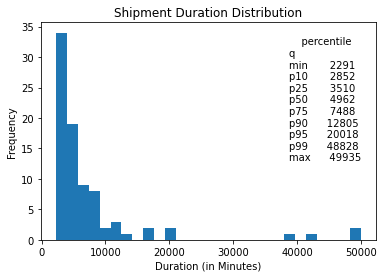

Mean Duration: 7741.5


In [201]:
def get_percentiles(s, q=None):
    if q is None:
        q = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    q_name = ['min'] + [f'p{int(100*i)}' for i in q] + ['max']
    p = [s.min()] + [round(s.quantile(i)) for i in q] + [s.max()]
    p_df = pd.DataFrame(np.column_stack((q_name, p)), columns=['q', 'percentile'])
    return p_df.set_index('q')

plt.hist(df.totalMinutes, bins=max(round(df.shape[0]/3),5))
plt.title('Shipment Duration Distribution')
plt.ylabel('Frequency')
plt.xlabel('Duration (in Minutes)')
plt.figtext(0.7, 0.4, get_percentiles(df.totalMinutes).to_string())
plt.show()
print(f'Mean Duration: {round(df.totalMinutes.mean(),1)}')

## Find Shortest Routes with GDS Path Finding
Demonstrate finding optimal paths between common points using mean time
Show how to lookup historic route performance using path index and other features (do we need a compound index instead of a concatenated one)

In [202]:
NODE_PROJ_QUERY = '''
        MATCH(n)
        WHERE n:EntryPoint OR n:DepartureWarehouse OR n:DeparturePoint OR n:ArrivalWarehouse OR n:TransferPoint OR n:Destination
        RETURN id(n) as id, labels(n) as labels
        '''
REL_PROJ_QUERY = '''
        MATCH(n0)-[r:RECEPTION|DEPARTURE|TRANSPORT|DELIVERY]->(n1)
        RETURN id(n0) AS source, id(n1) AS target, type(r) AS type, avg(r.effectiveMinutes) AS averageEffectiveMinutes
        '''

In [203]:
clear_all_graphs()
g, _ = gds.graph.project.cypher('proj', NODE_PROJ_QUERY, REL_PROJ_QUERY)
_

nodeQuery            MATCH(n)\n        WHERE n:EntryPoint OR n:DepartureWarehouse OR n:DeparturePoint OR n:ArrivalWarehouse OR n:TransferPoint OR n:Destination\n        RETURN id(n) as id, labels(n) as labels
relationshipQuery    MATCH(n0)-[r:RECEPTION|DEPARTURE|TRANSPORT|DELIVERY]->(n1)\n        RETURN id(n0) AS source, id(n1) AS target, type(r) AS type, avg(r.effectiveMinutes) AS averageEffectiveMinutes         
graphName            proj                                                                                                                                                                                       
nodeCount            1422                                                                                                                                                                                       
relationshipCount    2024                                                                                                                                           

In [204]:
source_airport_name = 'Moodytown'
target_airport_name = 'Davisfort'

source_node_id = gds.find_node_id(['EntryPoint'], {'name': source_airport_name})
target_node_id = gds.find_node_id(['Destination'], {'name': target_airport_name})
yen_df = gds.shortestPath.yens.stream(g, sourceNode=source_node_id, targetNode=target_node_id, k=5, relationshipWeightProperty='averageEffectiveMinutes')

In [205]:
def get_airport_names(path):
    res = []
    current_name =''
    for node in path.nodes:
        new_name = node.get('name')
        if new_name != current_name:
            res.append(new_name)
            current_name=new_name
    return res
yen_df['airportPath'] = yen_df.path.apply(get_airport_names)
yen_df[['sourceNode', 'targetNode','totalCost','airportPath']]

,sourceNode,targetNode,totalCost,airportPath
0,1046,864,3743.273964,"[Moodytown, Davisfort]"
1,1046,864,4409.658716,"[Moodytown, Michaelstad, Davisfort]"
2,1046,864,4588.759270,"[Moodytown, Wandaborough, Davisfort]"
3,1046,864,4617.841660,"[Moodytown, Matthewport, Davisfort]"
4,1046,864,4696.503596,"[Moodytown, Bryanside, Davisfort]"


In [206]:
pd.options.display.width = 0
pd.options.display.max_colwidth = 0

target_node_id_2 = gds.find_node_id(['Destination'], {'name': 'Sandersshire'})

yen_df = gds.shortestPath.yens.stream(g, sourceNode=source_node_id, targetNode=target_node_id_2, k=20, relationshipWeightProperty='averageEffectiveMinutes')
yen_df['airportPath'] = yen_df.path.apply(get_airport_names)
yen_df[['sourceNode', 'targetNode','totalCost','airportPath']]

,sourceNode,targetNode,totalCost,airportPath
0,1046,1723,5208.344321,"[Moodytown, Shanefort, Sandersshire]"
1,1046,1723,5715.502545,"[Moodytown, Ramoshaven, Shanefort, Sandersshire]"
2,1046,1723,5719.924774,"[Moodytown, Davisfort, Sandersshire]"
3,1046,1723,5912.069427,"[Moodytown, Michaelstad, Shanefort, Sandersshire]"
4,1046,1723,6011.366366,"[Moodytown, Wandaborough, Shanefort, Sandersshire]"
5,1046,1723,6087.670836,"[Moodytown, Richardberg, Sandersshire]"
6,1046,1723,6120.390428,"[Moodytown, Lisaton, Shanefort, Sandersshire]"
7,1046,1723,6215.389810,"[Moodytown, Grayshire, Shanefort, Sandersshire]"
8,1046,1723,6348.892664,"[Moodytown, Bryanside, Brownberg, Sandersshire]"
9,1046,1723,6386.309525,"[Moodytown, Michaelstad, Davisfort, Sandersshire]"


In [207]:
gds.run_cypher('MATCH(n) WHERE id(n) = $id RETURN n.airportId AS airportId', params={'id':target_node_id_2}).airportId[0]

468

In [208]:
target_airport_id_2 = gds.run_cypher('MATCH(n) WHERE id(n) = $id RETURN n.airportId AS airportId', params={'id':target_node_id_2}).airportId[0]

df = gds.run_cypher('''
    MATCH()-[r {pathIndex:$pathIndex}]->(n) WHERE r.legNumber > 0
    WITH r.legId AS incomingLegId, r.shipmentId AS shipmentId, sum(r.effectiveMinutes) AS incomingMinutes, collect(DISTINCT n.name) as incomingAirportNames
    MATCH()-[r {shipmentId: shipmentId}]->(n) WHERE r.legNumber < 0
    WITH incomingLegId, r.legId AS outgoingLegId, shipmentId, incomingMinutes, sum(r.effectiveMinutes) AS outgoingMinutes,
        incomingAirportNames, collect(DISTINCT n.name) as outgoingAirportNames
    RETURN incomingLegId, outgoingLegId, shipmentId, incomingMinutes, outgoingMinutes, (incomingMinutes + outgoingMinutes) AS totalMinutes,
    incomingAirportNames, outgoingAirportNames
    ORDER BY totalMinutes
''', params = {'pathIndex': f'{source_airport_id}-{target_airport_id_2}'})
df

,incomingLegId,outgoingLegId,shipmentId,incomingMinutes,outgoingMinutes,totalMinutes,incomingAirportNames,outgoingAirportNames
0,4454,5766,3200,1142,3259,4401,"[Moodytown, Richardberg]","[Richardberg, Sandersshire]"
1,8854,2379,1294,1663,2899,4562,"[Davisfort, Moodytown]","[Davisfort, Sandersshire]"
2,9753,5385,3609,435,4359,4794,"[Bryanside, Moodytown]","[Bryanside, Brownberg, Sandersshire]"
3,8768,13241,2775,2082,2921,5003,"[Davisfort, Moodytown]","[Davisfort, Sandersshire]"
4,1923,14467,709,2084,2949,5033,"[Davisfort, Moodytown]","[Davisfort, Sandersshire]"
5,10760,5385,3609,699,4359,5058,"[Bryanside, Moodytown]","[Bryanside, Brownberg, Sandersshire]"
6,10479,9020,2848,890,4296,5186,"[Bryanside, Moodytown]","[Bryanside, Brownberg, Sandersshire]"
7,2606,5385,3609,1158,4359,5517,"[Bryanside, Moodytown]","[Bryanside, Brownberg, Sandersshire]"
8,4089,11427,1664,2618,3029,5647,"[Lisaton, Moodytown]","[Lisaton, Sandersshire, Shanefort]"
9,10458,8613,3547,422,5370,5792,"[Moodytown, Michaelstad]","[Sandersshire, Brownberg, Michaelstad]"


## Freight Forwarding Combinations

In [209]:
def get_yen_dfs(g, source_node_ids, target_node_ids, k, max_avg_time=np.Inf):
    df_list = []
    for source_node_id in source_node_ids:
        for target_node_id in target_node_ids:
            tdf = gds.shortestPath.yens.stream(g, sourceNode=source_node_id, targetNode=target_node_id,
                                               k=k, relationshipWeightProperty='averageEffectiveMinutes')
            if max_avg_time < np.Inf:
                tdf = tdf[tdf.totalCost <= max_avg_time]
            df_list.append(tdf)
    return df_list

def get_solution_costs(row, path_dfs):
    solution = row.solutionIndex
    rels = {}
    path_costs = []
    for n in range(len(solution)):
        path_costs.append(path_dfs[n].totalCost[solution[n]])
        for r in path_dfs[n].path[solution[n]].relationships:
            rels[f'{r.start_node.id}-{r.end_node.id}'] = r
    return sum([r.get('cost') for r in rels.values()]), path_costs, list(rels.values())


def top_k_solutions(g, source_node_ids, target_node_ids, top_k=10, yen_candidates=10, max_avg_time=np.Inf):
    #get paths
    path_dfs = get_yen_dfs(g, source_node_ids, target_node_ids, yen_candidates, max_avg_time)
    #get solutions
    solution_df = pd.DataFrame(itertools.product(*[range(path_df.shape[0]) for path_df in path_dfs]))\
        .apply(tuple, axis=1).to_frame(name='solutionIndex')
    solution_df[['totalCost','pathCosts', 'relationships']] = solution_df.apply(get_solution_costs,
                                                                                args=([path_dfs]), axis=1, result_type='expand')
    # return top solutions
    return solution_df.sort_values('totalCost')[:top_k].reset_index(drop=True)

def top_k_solutions_from_names(g, source_airport_names, target_airport_name, top_k=10, yen_candidates=10, max_avg_time=np.Inf):
    source_node_ids = [gds.find_node_id(['EntryPoint'], {'name': i}) for i in source_airport_names]
    target_node_ids = [gds.find_node_id(['Destination'], {'name': target_airport_name})]
    return top_k_solutions(g, source_node_ids, target_node_ids, top_k=top_k, yen_candidates=yen_candidates, max_avg_time=max_avg_time)

def top_k_solutions_from_airport_ids(g, source_airport_ids, target_airport_id, top_k=10, yen_candidates=10, max_avg_time=np.Inf):
    source_node_ids = [gds.find_node_id(['EntryPoint'], {'airportId': i}) for i in source_airport_ids]
    target_node_ids = [gds.find_node_id(['Destination'], {'airportId': target_airport_id})]
    return top_k_solutions(g, source_node_ids, target_node_ids, top_k=top_k, yen_candidates=yen_candidates, max_avg_time=max_avg_time)

In [210]:
source_airport_names = ['Brownberg', 'Moodytown', 'Wandaborough', 'Richardberg']
target_airport_name = 'Sandersshire'
top_k_df = top_k_solutions_from_names(g, source_airport_names, target_airport_name)
top_k_df[['solutionIndex', 'totalCost', 'pathCosts']]

,solutionIndex,totalCost,pathCosts
0,"(2, 0, 0, 1)",12466.772236,"[4619.049646440211, 5208.344320769946, 4349.129699336236, 6535.08500916388]"
1,"(0, 0, 0, 1)",12527.402671,"[3040.020833333333, 5208.344320769946, 4349.129699336236, 6535.08500916388]"
2,"(2, 1, 0, 1)",12973.930460,"[4619.049646440211, 5715.5025446598775, 4349.129699336236, 6535.08500916388]"
3,"(0, 1, 0, 1)",13034.560895,"[3040.020833333333, 5715.5025446598775, 4349.129699336236, 6535.08500916388]"
4,"(2, 0, 2, 1)",13037.688624,"[4619.049646440211, 5208.344320769946, 4920.046087296103, 6535.08500916388]"
5,"(2, 4, 0, 1)",13065.902977,"[4619.049646440211, 6011.366365614366, 4349.129699336236, 6535.08500916388]"
6,"(0, 0, 2, 1)",13098.319059,"[3040.020833333333, 5208.344320769946, 4920.046087296103, 6535.08500916388]"
7,"(2, 1, 2, 1)",13113.269925,"[4619.049646440211, 5715.5025446598775, 4920.046087296103, 6535.08500916388]"
8,"(2, 0, 3, 1)",13125.501985,"[4619.049646440211, 5208.344320769946, 5007.859447619989, 6535.08500916388]"
9,"(0, 4, 0, 1)",13126.533412,"[3040.020833333333, 6011.366365614366, 4349.129699336236, 6535.08500916388]"


In [211]:
#write best path to DB to visualize results
def format_nodes_and_rels(relationships):
    records = []
    for r in relationships:
        records.append({'sourceNodeId': r.start_node.id, 'targetNodeId': r.end_node.id, 'cost': r.get('cost')})
    rel_df = pd.DataFrame.from_records(records)
    return pd.DataFrame(set(rel_df.sourceNodeId).union(rel_df.targetNodeId), columns = ['nodeId']), rel_df

node_df, rels_df  = format_nodes_and_rels(top_k_df.relationships[0])
gds.run_cypher('''
        UNWIND $rels AS rels
        WITH toInteger(rels.sourceNodeId) AS sourceNodeId,
            toInteger(rels.targetNodeId) AS targetNodeId,
            rels.cost AS cost
        MATCH(n1) WHERE id(n1) = sourceNodeId
        MATCH(n2) WHERE id(n2) = targetNodeId
        MERGE(n1)-[r:BEST_YENS_PATH {cost: cost}]->(n2)
''', params ={'rels': rels_df.to_dict('records')})

""


In [212]:
source_node_id_2 = gds.find_node_id(['EntryPoint'], {'name': 'Richardberg'})

yen_df = gds.shortestPath.yens.stream(g, sourceNode=source_node_id_2, targetNode=target_node_id_2, k=4, relationshipWeightProperty='averageEffectiveMinutes')
yen_df['airportPath'] = yen_df.path.apply(get_airport_names)
yen_df[['sourceNode', 'targetNode','totalCost','airportPath']]

,sourceNode,targetNode,totalCost,airportPath
0,1061,1723,5629.324223,"[Richardberg, Sandersshire]"
1,1061,1723,6535.085009,"[Richardberg, Shanefort, Sandersshire]"
2,1061,1723,6911.991264,"[Richardberg, Brownberg, Sandersshire]"
3,1061,1723,6927.236772,"[Richardberg, Davisfort, Sandersshire]"


In [213]:
gds.run_cypher('MATCH()-[r:BEST_YENS_PATH]->() DELETE r')

""


In [214]:
top_k_df = top_k_solutions_from_names(g, source_airport_names, target_airport_name, max_avg_time=6000.0)
top_k_df[['solutionIndex', 'totalCost', 'pathCosts']]

,solutionIndex,totalCost,pathCosts
0,"(2, 0, 0, 0)",13200.670698,"[4619.049646440211, 5208.344320769946, 4349.129699336236, 5629.324222812856]"
1,"(0, 0, 0, 0)",13261.301133,"[3040.020833333333, 5208.344320769946, 4349.129699336236, 5629.324222812856]"
2,"(2, 1, 0, 0)",13707.828922,"[4619.049646440211, 5715.5025446598775, 4349.129699336236, 5629.324222812856]"
3,"(0, 1, 0, 0)",13768.459357,"[3040.020833333333, 5715.5025446598775, 4349.129699336236, 5629.324222812856]"
4,"(2, 0, 2, 0)",13771.587086,"[4619.049646440211, 5208.344320769946, 4920.046087296103, 5629.324222812856]"
5,"(0, 0, 2, 0)",13832.217521,"[3040.020833333333, 5208.344320769946, 4920.046087296103, 5629.324222812856]"
6,"(2, 1, 2, 0)",13847.168387,"[4619.049646440211, 5715.5025446598775, 4920.046087296103, 5629.324222812856]"
7,"(2, 0, 3, 0)",13859.400446,"[4619.049646440211, 5208.344320769946, 5007.859447619989, 5629.324222812856]"
8,"(2, 3, 0, 0)",13904.395805,"[4619.049646440211, 5912.069427455579, 4349.129699336236, 5629.324222812856]"
9,"(2, 3, 3, 0)",13906.704500,"[4619.049646440211, 5912.069427455579, 5007.859447619989, 5629.324222812856]"


In [215]:
def format_nodes_and_rels(relationships):
    records = []
    for r in relationships:
        records.append({'sourceNodeId': r.start_node.id, 'targetNodeId': r.end_node.id, 'cost': r.get('cost')})
    rel_df = pd.DataFrame.from_records(records)
    return pd.DataFrame(set(rel_df.sourceNodeId).union(rel_df.targetNodeId), columns = ['nodeId']), rel_df

node_df, rels_df  = format_nodes_and_rels(top_k_df.relationships[0])
gds.run_cypher('''
        UNWIND $rels AS rels
        WITH toInteger(rels.sourceNodeId) AS sourceNodeId,
            toInteger(rels.targetNodeId) AS targetNodeId,
            rels.cost AS cost
        MATCH(n1) WHERE id(n1) = sourceNodeId
        MATCH(n2) WHERE id(n2) = targetNodeId
        MERGE(n1)-[r:BEST_YENS_PATH {cost: cost}]->(n2)
''', params ={'rels': rels_df.to_dict('records')})

""


In [216]:
gds.run_cypher('MATCH()-[r:BEST_YENS_PATH]->() DELETE r')

""
